In [141]:
import pandas as pd
import boto
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import time

## PLS for One Product Column

In [142]:
user_history = pd.read_csv("user_history.csv")
user_ratings = pd.read_csv("RATINGS_full.csv")

columns = [col for col in user_ratings.columns]



In [143]:
#Select which product you want to predict ratings for and add this product column to the end of user_history
product = "secret postage"

prod_col = []
for i in range(len(user_ratings[product])):
        prod_col.append(user_ratings[product][i])
        

user_history[product] = prod_col


In [144]:
data_not_nan = user_history[~user_history[product].isnull()]
#print(data_not_nan)

data_is_nan = user_history[user_history[product].isna()]
#print(data_is_nan)

train_num = math.floor((3/4)*len(data_not_nan))

data_train = data_not_nan.iloc[0:train_num,:]
data_val = data_not_nan.iloc[train_num:,:]
data_test = user_history

# Split the columns in X and Y
X_colnames = user_history.columns[:-1]
Y_colnames = user_history.columns[-1:]


# Split each train, val and test into two arrays
X_train = data_train[X_colnames].values
Y_train = data_train[Y_colnames].values

X_val = data_val[X_colnames].values
Y_val = data_val[Y_colnames].values

X_test = data_test[X_colnames].values
Y_test = data_test[Y_colnames].values

In [145]:
# Regression: Compute the validation error for each n_comp 
secret_postage_plot = []
best_r2 = 0
best_ncmop = 0

for n_comp in range(1, 101):
    my_plsr = PLSRegression(n_components=n_comp, scale=True)
    my_plsr.fit(X_train, Y_train)
    preds = my_plsr.predict(X_val)
    
    r2 = r2_score(preds, Y_val)
    if r2 > best_r2:
        best_r2 = r2
        best_ncomp = n_comp
        
    secret_postage_rmse = sqrt(mean_squared_error(Y_val[:,0] ,preds[:,0]))
    secret_postage_plot.append( secret_postage_rmse)
    



Best r2 score: 0.8857673925245141
Best number of components: 12


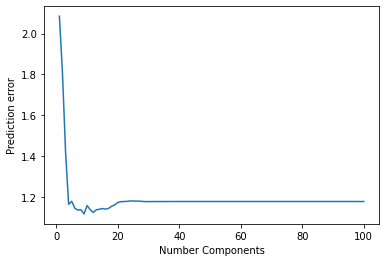

In [146]:
# Create the three plots using matplotlib
#fig, axs = plt.subplots(1)

print("Best r2 score: " + str(best_r2))
print("Best number of components: " + str(best_ncomp))
plt.plot(range(1, 101), secret_postage_plot)
plt.xlabel("Number Components")
plt.ylabel("Prediction error")
plt.show()

In [147]:
best_model = PLSRegression(n_components=best_ncomp, scale=True)
best_model.fit(X_train, Y_train)
test_preds = best_model.predict(X_test)
#print(r2_score(Y_test, test_preds))


In [148]:
for i in range(len(test_preds)):
    if(test_preds[i] > 10.0):
        test_preds[i] = 10.0
    if(test_preds[i] < 0.0):
        test_preds[i] = 0.0
    #print(test_preds[i])
    #print(user_ratings["secret postage"][i])

In [149]:
user_ratings[product] = test_preds

user_ratings[product]

0       4.355478
1       4.055342
2       8.112566
3       0.000000
4       9.931221
          ...   
4495    6.437709
4496    8.016110
4497    5.797996
4498    5.026763
4499    2.931074
Name: secret postage, Length: 4500, dtype: float64

## PLS for All Product Columns

In [150]:
starttime = time.time()
total_r2score = 0
for i in range(1, len(columns)):
    product = columns[i]
    print("Processing col: " + str(product))
    
    #Add product column to the end of user_history
    prod_col = []
    for i in range(len(user_ratings[product])):
        prod_col.append(user_ratings[product][i])
        
    user_history[product] = prod_col
    
    
    #Split data into train, validation, test
    data_not_nan = user_history[~user_history[product].isnull()]
    data_is_nan = user_history[user_history[product].isna()]

    train_num = math.floor((3/4)*len(data_not_nan))

    data_train = data_not_nan.iloc[0:train_num,:]
    data_val = data_not_nan.iloc[train_num:,:]
    data_test = user_history

    X_colnames = user_history.columns[:-1]
    Y_colnames = user_history.columns[-1:]


    X_train = data_train[X_colnames].values
    Y_train = data_train[Y_colnames].values

    X_val = data_val[X_colnames].values
    Y_val = data_val[Y_colnames].values

    X_test = data_test[X_colnames].values
    Y_test = data_test[Y_colnames].values
    
    
    
    # Train Regression Model
    best_r2 = 0
    best_ncmop = 0

    for n_comp in range(1, 101):
        plsr = PLSRegression(n_components=n_comp, scale=True)
        plsr.fit(X_train, Y_train)
        preds = plsr.predict(X_val)
    
        r2 = r2_score(preds, Y_val)
        if r2 > best_r2:
            best_r2 = r2
            best_ncomp = n_comp
        
        product_rmse = sqrt(mean_squared_error(Y_val[:,0] ,preds[:,0]))
        
    total_r2score += best_r2
    #print("Best r2 score: " + str(best_r2))
    #print("Best number of components: " + str(best_ncomp))
    #print()
    
    
    #Predict for all users using the model with the best component number
    best_model = PLSRegression(n_components=best_ncomp, scale=True)
    best_model.fit(X_train, Y_train)
    test_preds = best_model.predict(X_test)
    
    for i in range(len(test_preds)):
        if(test_preds[i] > 10.0):
            test_preds[i] = 10.0
        if(test_preds[i] < 0.0):
            test_preds[i] = 0.0
        
        
    #Update user_ratings matrix with new product column and reset user_history matrix for the next product
    user_ratings[product] = test_preds
    user_history.drop(product, axis=1, inplace=True)
    
print("Finished. Runtime: " + str(time.time() - starttime))
print("Average r2 score: " + str(total_r2score/75))

power = 2
user_ratings.to_csv('results/distance_' + str(power) + '.csv')

Processing col: secret postage
Processing col: violet saga
Processing col: pepper chicago
Processing col: nina sailor
Processing col: front salami
Processing col: motor modular
Processing col: calypso zigzag
Processing col: imagine disco
Processing col: kitchen active
Processing col: banjo ladder
Processing col: mexico stretch
Processing col: meteor slalom
Processing col: spend oberon
Processing col: oregano option
Processing col: popcorn shannon
Processing col: ninja history
Processing col: saint desert
Processing col: barcode arnold
Processing col: distant list
Processing col: topic rover
Processing col: kayak analog
Processing col: optimal recycle
Processing col: process volume
Processing col: lobster diana
Processing col: risk corona
Processing col: company polo
Processing col: image jessica
Processing col: forum bravo
Processing col: house vodka
Processing col: salsa impress
Processing col: update lola
Processing col: sensor child
Processing col: peru king
Processing col: apropos 

In [138]:
user_ratings

,USER ID,secret postage,violet saga,pepper chicago,nina sailor,front salami,motor modular,calypso zigzag,imagine disco,kitchen active,...,salute joshua,story respect,vista queen,ritual product,panic inside,current pony,stop tropic,tripod stand,tourist micro,bazooka diagram
0,0,4.490330,4.807356,2.934577,1.352662,3.147821,9.390969,6.011851,7.235100,3.425220,...,2.694071,8.312491,4.798466,7.923360,7.322660,3.438929,1.848871,6.492189,1.733935,6.531612
1,1,4.057624,4.311371,7.240553,3.748868,0.000000,5.931379,3.214764,6.646863,1.531161,...,0.944201,8.234379,10.000000,2.426783,0.000000,6.692452,0.000000,7.549636,10.000000,2.904479
2,2,8.011239,1.834633,1.841324,0.000000,8.763295,2.333728,1.095284,0.025339,3.821663,...,5.675978,0.315173,3.626487,3.712143,7.938426,1.275940,1.937821,3.119192,5.901321,0.000000
3,3,0.000000,0.000000,3.870442,0.000000,6.532043,4.986048,5.123256,4.194081,0.000000,...,0.000000,10.000000,4.272079,7.550210,10.000000,10.000000,0.860184,0.000000,0.779544,10.000000
4,4,9.617724,3.874219,3.436292,0.537266,8.201690,6.097520,2.276198,1.534370,3.198541,...,6.312999,0.000000,5.459648,6.670322,10.000000,2.174187,4.298678,7.685800,3.808074,0.251829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,4495,6.369893,3.364690,3.257113,2.694126,5.991599,5.708329,3.680762,3.358052,4.604674,...,5.095166,3.169004,4.781825,5.242397,6.551737,4.151854,3.534579,4.321354,4.728973,3.872048
4496,4496,7.714984,2.405917,2.946760,2.444756,8.847710,0.312880,9.037279,3.014420,8.123978,...,10.000000,2.061013,0.000000,8.132982,7.963934,2.440106,10.000000,0.000000,1.467034,3.957563
4497,4497,5.878304,6.441476,3.947207,5.041359,4.910657,6.794300,4.748277,5.327165,5.469397,...,6.121148,4.491055,4.589182,5.583904,5.194446,3.441215,5.335899,6.572246,4.994620,4.606361
4498,4498,5.099356,6.829382,6.518073,8.160263,2.939509,9.227781,6.125354,7.050475,5.838808,...,4.468767,5.403104,7.483500,7.524587,5.197707,7.521418,5.894799,7.955668,3.263290,7.696351


In [140]:
#Results
import numpy as np

y_true = pd.read_csv("RATINGS_full.csv")
sorted_columns = sorted(y_true.columns[1:])
sorted_columns.insert(0, y_true.columns[0])
y_true = y_true.reindex(sorted_columns, axis=1)

row_index = []
column_index = []

for i in range(len(y_true)):
    for j in range(1, len(y_true.iloc[i])):
        if not np.isnan(y_true.iloc[i][j]):
            row_index.append(i)
            column_index.append(j)
            
y_pred = user_ratings
sorted_columns = sorted(y_pred.columns[1:])
sorted_columns.insert(0, y_pred.columns[0])
y_pred = y_pred.reindex(sorted_columns, axis=1)


denom = 0
loss = 0
for i in range(len(row_index)):
    y_true_val = y_true.iloc[row_index[i]][column_index[i]]
    y_pred_val = y_pred.iloc[row_index[i]][column_index[i]]
    denom += y_true_val**2
    loss += (y_pred_val - y_true_val)**2
    
print()
print("Relative loss: " + str(loss/denom))
print("Absolute loss: " + str(loss))

Calculating for user 0
Calculating for user 1
Calculating for user 2
Calculating for user 3
Calculating for user 4
Calculating for user 5
Calculating for user 6
Calculating for user 7
Calculating for user 8
Calculating for user 9
Calculating for user 10
Calculating for user 11
Calculating for user 12
Calculating for user 13
Calculating for user 14
Calculating for user 15
Calculating for user 16
Calculating for user 17
Calculating for user 18
Calculating for user 19
Calculating for user 20
Calculating for user 21
Calculating for user 22
Calculating for user 23
Calculating for user 24
Calculating for user 25
Calculating for user 26
Calculating for user 27
Calculating for user 28
Calculating for user 29
Calculating for user 30
Calculating for user 31
Calculating for user 32
Calculating for user 33
Calculating for user 34
Calculating for user 35
Calculating for user 36
Calculating for user 37
Calculating for user 38
Calculating for user 39
Calculating for user 40
Calculating for user 41
Ca

Calculating for user 665
Calculating for user 666
Calculating for user 667
Calculating for user 668
Calculating for user 669
Calculating for user 670
Calculating for user 671
Calculating for user 672
Calculating for user 673
Calculating for user 674
Calculating for user 675
Calculating for user 676
Calculating for user 677
Calculating for user 678
Calculating for user 679
Calculating for user 680
Calculating for user 681
Calculating for user 682
Calculating for user 683
Calculating for user 684
Calculating for user 685
Calculating for user 686
Calculating for user 687
Calculating for user 688
Calculating for user 689
Calculating for user 690
Calculating for user 691
Calculating for user 692
Calculating for user 693
Calculating for user 694
Calculating for user 695
Calculating for user 696
Calculating for user 697
Calculating for user 698
Calculating for user 699
Calculating for user 700
Calculating for user 701
Calculating for user 702
Calculating for user 703
Calculating for user 704


Calculating for user 1205
Calculating for user 1206
Calculating for user 1207
Calculating for user 1208
Calculating for user 1209
Calculating for user 1210
Calculating for user 1211
Calculating for user 1212
Calculating for user 1213
Calculating for user 1214
Calculating for user 1215
Calculating for user 1216
Calculating for user 1217
Calculating for user 1218
Calculating for user 1219
Calculating for user 1220
Calculating for user 1221
Calculating for user 1222
Calculating for user 1223
Calculating for user 1224
Calculating for user 1225
Calculating for user 1226
Calculating for user 1227
Calculating for user 1228
Calculating for user 1229
Calculating for user 1230
Calculating for user 1231
Calculating for user 1232
Calculating for user 1233
Calculating for user 1234
Calculating for user 1235
Calculating for user 1236
Calculating for user 1237
Calculating for user 1238
Calculating for user 1239
Calculating for user 1240
Calculating for user 1241
Calculating for user 1242
Calculating 

Calculating for user 1829
Calculating for user 1830
Calculating for user 1831
Calculating for user 1832
Calculating for user 1833
Calculating for user 1834
Calculating for user 1835
Calculating for user 1836
Calculating for user 1837
Calculating for user 1838
Calculating for user 1839
Calculating for user 1840
Calculating for user 1841
Calculating for user 1842
Calculating for user 1843
Calculating for user 1844
Calculating for user 1845
Calculating for user 1846
Calculating for user 1847
Calculating for user 1848
Calculating for user 1849
Calculating for user 1850
Calculating for user 1851
Calculating for user 1852
Calculating for user 1853
Calculating for user 1854
Calculating for user 1855
Calculating for user 1856
Calculating for user 1857
Calculating for user 1858
Calculating for user 1859
Calculating for user 1860
Calculating for user 1861
Calculating for user 1862
Calculating for user 1863
Calculating for user 1864
Calculating for user 1865
Calculating for user 1866
Calculating 

Calculating for user 2463
Calculating for user 2464
Calculating for user 2465
Calculating for user 2466
Calculating for user 2467
Calculating for user 2468
Calculating for user 2469
Calculating for user 2470
Calculating for user 2471
Calculating for user 2472
Calculating for user 2473
Calculating for user 2474
Calculating for user 2475
Calculating for user 2476
Calculating for user 2477
Calculating for user 2478
Calculating for user 2479
Calculating for user 2480
Calculating for user 2481
Calculating for user 2482
Calculating for user 2483
Calculating for user 2484
Calculating for user 2485
Calculating for user 2486
Calculating for user 2487
Calculating for user 2488
Calculating for user 2489
Calculating for user 2490
Calculating for user 2491
Calculating for user 2492
Calculating for user 2493
Calculating for user 2494
Calculating for user 2495
Calculating for user 2496
Calculating for user 2497
Calculating for user 2498
Calculating for user 2499
Calculating for user 2500
Calculating 

Calculating for user 3094
Calculating for user 3095
Calculating for user 3096
Calculating for user 3097
Calculating for user 3098
Calculating for user 3099
Calculating for user 3100
Calculating for user 3101
Calculating for user 3102
Calculating for user 3103
Calculating for user 3104
Calculating for user 3105
Calculating for user 3106
Calculating for user 3107
Calculating for user 3108
Calculating for user 3109
Calculating for user 3110
Calculating for user 3111
Calculating for user 3112
Calculating for user 3113
Calculating for user 3114
Calculating for user 3115
Calculating for user 3116
Calculating for user 3117
Calculating for user 3118
Calculating for user 3119
Calculating for user 3120
Calculating for user 3121
Calculating for user 3122
Calculating for user 3123
Calculating for user 3124
Calculating for user 3125
Calculating for user 3126
Calculating for user 3127
Calculating for user 3128
Calculating for user 3129
Calculating for user 3130
Calculating for user 3131
Calculating 

Calculating for user 3719
Calculating for user 3720
Calculating for user 3721
Calculating for user 3722
Calculating for user 3723
Calculating for user 3724
Calculating for user 3725
Calculating for user 3726
Calculating for user 3727
Calculating for user 3728
Calculating for user 3729
Calculating for user 3730
Calculating for user 3731
Calculating for user 3732
Calculating for user 3733
Calculating for user 3734
Calculating for user 3735
Calculating for user 3736
Calculating for user 3737
Calculating for user 3738
Calculating for user 3739
Calculating for user 3740
Calculating for user 3741
Calculating for user 3742
Calculating for user 3743
Calculating for user 3744
Calculating for user 3745
Calculating for user 3746
Calculating for user 3747
Calculating for user 3748
Calculating for user 3749
Calculating for user 3750
Calculating for user 3751
Calculating for user 3752
Calculating for user 3753
Calculating for user 3754
Calculating for user 3755
Calculating for user 3756
Calculating 

Calculating for user 4336
Calculating for user 4337
Calculating for user 4338
Calculating for user 4339
Calculating for user 4340
Calculating for user 4341
Calculating for user 4342
Calculating for user 4343
Calculating for user 4344
Calculating for user 4345
Calculating for user 4346
Calculating for user 4347
Calculating for user 4348
Calculating for user 4349
Calculating for user 4350
Calculating for user 4351
Calculating for user 4352
Calculating for user 4353
Calculating for user 4354
Calculating for user 4355
Calculating for user 4356
Calculating for user 4357
Calculating for user 4358
Calculating for user 4359
Calculating for user 4360
Calculating for user 4361
Calculating for user 4362
Calculating for user 4363
Calculating for user 4364
Calculating for user 4365
Calculating for user 4366
Calculating for user 4367
Calculating for user 4368
Calculating for user 4369
Calculating for user 4370
Calculating for user 4371
Calculating for user 4372
Calculating for user 4373
Calculating 

Calculating for user 4949
Calculating for user 4950
Calculating for user 4951
Calculating for user 4952
Calculating for user 4953
Calculating for user 4954
Calculating for user 4955
Calculating for user 4956
Calculating for user 4957
Calculating for user 4958
Calculating for user 4959
Calculating for user 4960
Calculating for user 4961
Calculating for user 4962
Calculating for user 4963
Calculating for user 4964
Calculating for user 4965
Calculating for user 4966
Calculating for user 4967
Calculating for user 4968
Calculating for user 4969
Calculating for user 4970
Calculating for user 4971
Calculating for user 4972
Calculating for user 4973
Calculating for user 4974
Calculating for user 4975
Calculating for user 4976
Calculating for user 4977
Calculating for user 4978
Calculating for user 4979
Calculating for user 4980
Calculating for user 4981
Calculating for user 4982
Calculating for user 4983
Calculating for user 4984
Calculating for user 4985
Calculating for user 4986
Calculating 

Calculating for user 5566
Calculating for user 5567
Calculating for user 5568
Calculating for user 5569
Calculating for user 5570
Calculating for user 5571
Calculating for user 5572
Calculating for user 5573
Calculating for user 5574
Calculating for user 5575
Calculating for user 5576
Calculating for user 5577
Calculating for user 5578
Calculating for user 5579
Calculating for user 5580
Calculating for user 5581
Calculating for user 5582
Calculating for user 5583
Calculating for user 5584
Calculating for user 5585
Calculating for user 5586
Calculating for user 5587
Calculating for user 5588
Calculating for user 5589
Calculating for user 5590
Calculating for user 5591
Calculating for user 5592
Calculating for user 5593
Calculating for user 5594
Calculating for user 5595
Calculating for user 5596
Calculating for user 5597
Calculating for user 5598
Calculating for user 5599
Calculating for user 5600
Calculating for user 5601
Calculating for user 5602
Calculating for user 5603
Calculating 

Calculating for user 6207
Calculating for user 6208
Calculating for user 6209
Calculating for user 6210
Calculating for user 6211
Calculating for user 6212
Calculating for user 6213
Calculating for user 6214
Calculating for user 6215
Calculating for user 6216
Calculating for user 6217
Calculating for user 6218
Calculating for user 6219
Calculating for user 6220
Calculating for user 6221
Calculating for user 6222
Calculating for user 6223
Calculating for user 6224
Calculating for user 6225
Calculating for user 6226
Calculating for user 6227
Calculating for user 6228
Calculating for user 6229
Calculating for user 6230
Calculating for user 6231
Calculating for user 6232
Calculating for user 6233
Calculating for user 6234
Calculating for user 6235
Calculating for user 6236
Calculating for user 6237
Calculating for user 6238
Calculating for user 6239
Calculating for user 6240
Calculating for user 6241
Calculating for user 6242
Calculating for user 6243
Calculating for user 6244
Calculating 

Calculating for user 6788
Calculating for user 6789
Calculating for user 6790
Calculating for user 6791
Calculating for user 6792
Calculating for user 6793
Calculating for user 6794
Calculating for user 6795
Calculating for user 6796
Calculating for user 6797
Calculating for user 6798
Calculating for user 6799
Calculating for user 6800
Calculating for user 6801
Calculating for user 6802
Calculating for user 6803
Calculating for user 6804
Calculating for user 6805
Calculating for user 6806
Calculating for user 6807
Calculating for user 6808
Calculating for user 6809
Calculating for user 6810
Calculating for user 6811
Calculating for user 6812
Calculating for user 6813
Calculating for user 6814
Calculating for user 6815
Calculating for user 6816
Calculating for user 6817
Calculating for user 6818
Calculating for user 6819
Calculating for user 6820
Calculating for user 6821
Calculating for user 6822
Calculating for user 6823
Calculating for user 6824
Calculating for user 6825
Calculating 

Calculating for user 7401
Calculating for user 7402
Calculating for user 7403
Calculating for user 7404
Calculating for user 7405
Calculating for user 7406
Calculating for user 7407
Calculating for user 7408
Calculating for user 7409
Calculating for user 7410
Calculating for user 7411
Calculating for user 7412
Calculating for user 7413
Calculating for user 7414
Calculating for user 7415
Calculating for user 7416
Calculating for user 7417
Calculating for user 7418
Calculating for user 7419
Calculating for user 7420
Calculating for user 7421
Calculating for user 7422
Calculating for user 7423
Calculating for user 7424
Calculating for user 7425
Calculating for user 7426
Calculating for user 7427
Calculating for user 7428
Calculating for user 7429
Calculating for user 7430
Calculating for user 7431
Calculating for user 7432
Calculating for user 7433
Calculating for user 7434
Calculating for user 7435
Calculating for user 7436
Calculating for user 7437
Calculating for user 7438
Calculating 

Calculating for user 7957
Calculating for user 7958
Calculating for user 7959
Calculating for user 7960
Calculating for user 7961
Calculating for user 7962
Calculating for user 7963
Calculating for user 7964
Calculating for user 7965
Calculating for user 7966
Calculating for user 7967
Calculating for user 7968
Calculating for user 7969
Calculating for user 7970
Calculating for user 7971
Calculating for user 7972
Calculating for user 7973
Calculating for user 7974
Calculating for user 7975
Calculating for user 7976
Calculating for user 7977
Calculating for user 7978
Calculating for user 7979
Calculating for user 7980
Calculating for user 7981
Calculating for user 7982
Calculating for user 7983
Calculating for user 7984
Calculating for user 7985
Calculating for user 7986
Calculating for user 7987
Calculating for user 7988
Calculating for user 7989
Calculating for user 7990
Calculating for user 7991
Calculating for user 7992
Calculating for user 7993
Calculating for user 7994
Calculating 

Calculating for user 8542
Calculating for user 8543
Calculating for user 8544
Calculating for user 8545
Calculating for user 8546
Calculating for user 8547
Calculating for user 8548
Calculating for user 8549
Calculating for user 8550
Calculating for user 8551
Calculating for user 8552
Calculating for user 8553
Calculating for user 8554
Calculating for user 8555
Calculating for user 8556
Calculating for user 8557
Calculating for user 8558
Calculating for user 8559
Calculating for user 8560
Calculating for user 8561
Calculating for user 8562
Calculating for user 8563
Calculating for user 8564
Calculating for user 8565
Calculating for user 8566
Calculating for user 8567
Calculating for user 8568
Calculating for user 8569
Calculating for user 8570
Calculating for user 8571
Calculating for user 8572
Calculating for user 8573
Calculating for user 8574
Calculating for user 8575
Calculating for user 8576
Calculating for user 8577
Calculating for user 8578
Calculating for user 8579
Calculating 

Calculating for user 9140
Calculating for user 9141
Calculating for user 9142
Calculating for user 9143
Calculating for user 9144
Calculating for user 9145
Calculating for user 9146
Calculating for user 9147
Calculating for user 9148
Calculating for user 9149
Calculating for user 9150
Calculating for user 9151
Calculating for user 9152
Calculating for user 9153
Calculating for user 9154
Calculating for user 9155
Calculating for user 9156
Calculating for user 9157
Calculating for user 9158
Calculating for user 9159
Calculating for user 9160
Calculating for user 9161
Calculating for user 9162
Calculating for user 9163
Calculating for user 9164
Calculating for user 9165
Calculating for user 9166
Calculating for user 9167
Calculating for user 9168
Calculating for user 9169
Calculating for user 9170
Calculating for user 9171
Calculating for user 9172
Calculating for user 9173
Calculating for user 9174
Calculating for user 9175
Calculating for user 9176
Calculating for user 9177
Calculating 

Calculating for user 9719
Calculating for user 9720
Calculating for user 9721
Calculating for user 9722
Calculating for user 9723
Calculating for user 9724
Calculating for user 9725
Calculating for user 9726
Calculating for user 9727
Calculating for user 9728
Calculating for user 9729
Calculating for user 9730
Calculating for user 9731
Calculating for user 9732
Calculating for user 9733
Calculating for user 9734
Calculating for user 9735
Calculating for user 9736
Calculating for user 9737
Calculating for user 9738
Calculating for user 9739
Calculating for user 9740
Calculating for user 9741
Calculating for user 9742
Calculating for user 9743
Calculating for user 9744
Calculating for user 9745
Calculating for user 9746
Calculating for user 9747
Calculating for user 9748
Calculating for user 9749
Calculating for user 9750
Calculating for user 9751
Calculating for user 9752
Calculating for user 9753
Calculating for user 9754
Calculating for user 9755
Calculating for user 9756
Calculating 

Calculating for user 10283
Calculating for user 10284
Calculating for user 10285
Calculating for user 10286
Calculating for user 10287
Calculating for user 10288
Calculating for user 10289
Calculating for user 10290
Calculating for user 10291
Calculating for user 10292
Calculating for user 10293
Calculating for user 10294
Calculating for user 10295
Calculating for user 10296
Calculating for user 10297
Calculating for user 10298
Calculating for user 10299
Calculating for user 10300
Calculating for user 10301
Calculating for user 10302
Calculating for user 10303
Calculating for user 10304
Calculating for user 10305
Calculating for user 10306
Calculating for user 10307
Calculating for user 10308
Calculating for user 10309
Calculating for user 10310
Calculating for user 10311
Calculating for user 10312
Calculating for user 10313
Calculating for user 10314
Calculating for user 10315
Calculating for user 10316
Calculating for user 10317
Calculating for user 10318
Calculating for user 10319
C

Calculating for user 10882
Calculating for user 10883
Calculating for user 10884
Calculating for user 10885
Calculating for user 10886
Calculating for user 10887
Calculating for user 10888
Calculating for user 10889
Calculating for user 10890
Calculating for user 10891
Calculating for user 10892
Calculating for user 10893
Calculating for user 10894
Calculating for user 10895
Calculating for user 10896
Calculating for user 10897
Calculating for user 10898
Calculating for user 10899
Calculating for user 10900
Calculating for user 10901
Calculating for user 10902
Calculating for user 10903
Calculating for user 10904
Calculating for user 10905
Calculating for user 10906
Calculating for user 10907
Calculating for user 10908
Calculating for user 10909
Calculating for user 10910
Calculating for user 10911
Calculating for user 10912
Calculating for user 10913
Calculating for user 10914
Calculating for user 10915
Calculating for user 10916
Calculating for user 10917
Calculating for user 10918
C

Calculating for user 11468
Calculating for user 11469
Calculating for user 11470
Calculating for user 11471
Calculating for user 11472
Calculating for user 11473
Calculating for user 11474
Calculating for user 11475
Calculating for user 11476
Calculating for user 11477
Calculating for user 11478
Calculating for user 11479
Calculating for user 11480
Calculating for user 11481
Calculating for user 11482
Calculating for user 11483
Calculating for user 11484
Calculating for user 11485
Calculating for user 11486
Calculating for user 11487
Calculating for user 11488
Calculating for user 11489
Calculating for user 11490
Calculating for user 11491
Calculating for user 11492
Calculating for user 11493
Calculating for user 11494
Calculating for user 11495
Calculating for user 11496
Calculating for user 11497
Calculating for user 11498
Calculating for user 11499
Calculating for user 11500
Calculating for user 11501
Calculating for user 11502
Calculating for user 11503
Calculating for user 11504
C

Calculating for user 12018
Calculating for user 12019
Calculating for user 12020
Calculating for user 12021
Calculating for user 12022
Calculating for user 12023
Calculating for user 12024
Calculating for user 12025
Calculating for user 12026
Calculating for user 12027
Calculating for user 12028
Calculating for user 12029
Calculating for user 12030
Calculating for user 12031
Calculating for user 12032
Calculating for user 12033
Calculating for user 12034
Calculating for user 12035
Calculating for user 12036
Calculating for user 12037
Calculating for user 12038
Calculating for user 12039
Calculating for user 12040
Calculating for user 12041
Calculating for user 12042
Calculating for user 12043
Calculating for user 12044
Calculating for user 12045
Calculating for user 12046
Calculating for user 12047
Calculating for user 12048
Calculating for user 12049
Calculating for user 12050
Calculating for user 12051
Calculating for user 12052
Calculating for user 12053
Calculating for user 12054
C

Calculating for user 12606
Calculating for user 12607
Calculating for user 12608
Calculating for user 12609
Calculating for user 12610
Calculating for user 12611
Calculating for user 12612
Calculating for user 12613
Calculating for user 12614
Calculating for user 12615
Calculating for user 12616
Calculating for user 12617
Calculating for user 12618
Calculating for user 12619
Calculating for user 12620
Calculating for user 12621
Calculating for user 12622
Calculating for user 12623
Calculating for user 12624
Calculating for user 12625
Calculating for user 12626
Calculating for user 12627
Calculating for user 12628
Calculating for user 12629
Calculating for user 12630
Calculating for user 12631
Calculating for user 12632
Calculating for user 12633
Calculating for user 12634
Calculating for user 12635
Calculating for user 12636
Calculating for user 12637
Calculating for user 12638
Calculating for user 12639
Calculating for user 12640
Calculating for user 12641
Calculating for user 12642
C

Calculating for user 13217
Calculating for user 13218
Calculating for user 13219
Calculating for user 13220
Calculating for user 13221
Calculating for user 13222
Calculating for user 13223
Calculating for user 13224
Calculating for user 13225
Calculating for user 13226
Calculating for user 13227
Calculating for user 13228
Calculating for user 13229
Calculating for user 13230
Calculating for user 13231
Calculating for user 13232
Calculating for user 13233
Calculating for user 13234
Calculating for user 13235
Calculating for user 13236
Calculating for user 13237
Calculating for user 13238
Calculating for user 13239
Calculating for user 13240
Calculating for user 13241
Calculating for user 13242
Calculating for user 13243
Calculating for user 13244
Calculating for user 13245
Calculating for user 13246
Calculating for user 13247
Calculating for user 13248
Calculating for user 13249
Calculating for user 13250
Calculating for user 13251
Calculating for user 13252
Calculating for user 13253
C

Calculating for user 13804
Calculating for user 13805
Calculating for user 13806
Calculating for user 13807
Calculating for user 13808
Calculating for user 13809
Calculating for user 13810
Calculating for user 13811
Calculating for user 13812
Calculating for user 13813
Calculating for user 13814
Calculating for user 13815
Calculating for user 13816
Calculating for user 13817
Calculating for user 13818
Calculating for user 13819
Calculating for user 13820
Calculating for user 13821
Calculating for user 13822
Calculating for user 13823
Calculating for user 13824
Calculating for user 13825
Calculating for user 13826
Calculating for user 13827
Calculating for user 13828
Calculating for user 13829
Calculating for user 13830
Calculating for user 13831
Calculating for user 13832
Calculating for user 13833
Calculating for user 13834
Calculating for user 13835
Calculating for user 13836
Calculating for user 13837
Calculating for user 13838
Calculating for user 13839
Calculating for user 13840
C

Calculating for user 14359
Calculating for user 14360
Calculating for user 14361
Calculating for user 14362
Calculating for user 14363
Calculating for user 14364
Calculating for user 14365
Calculating for user 14366
Calculating for user 14367
Calculating for user 14368
Calculating for user 14369
Calculating for user 14370
Calculating for user 14371
Calculating for user 14372
Calculating for user 14373
Calculating for user 14374
Calculating for user 14375
Calculating for user 14376
Calculating for user 14377
Calculating for user 14378
Calculating for user 14379
Calculating for user 14380
Calculating for user 14381
Calculating for user 14382
Calculating for user 14383
Calculating for user 14384
Calculating for user 14385
Calculating for user 14386
Calculating for user 14387
Calculating for user 14388
Calculating for user 14389
Calculating for user 14390
Calculating for user 14391
Calculating for user 14392
Calculating for user 14393
Calculating for user 14394
Calculating for user 14395
C

Calculating for user 14925
Calculating for user 14926
Calculating for user 14927
Calculating for user 14928
Calculating for user 14929
Calculating for user 14930
Calculating for user 14931
Calculating for user 14932
Calculating for user 14933
Calculating for user 14934
Calculating for user 14935
Calculating for user 14936
Calculating for user 14937
Calculating for user 14938
Calculating for user 14939
Calculating for user 14940
Calculating for user 14941
Calculating for user 14942
Calculating for user 14943
Calculating for user 14944
Calculating for user 14945
Calculating for user 14946
Calculating for user 14947
Calculating for user 14948
Calculating for user 14949
Calculating for user 14950
Calculating for user 14951
Calculating for user 14952
Calculating for user 14953
Calculating for user 14954
Calculating for user 14955
Calculating for user 14956
Calculating for user 14957
Calculating for user 14958
Calculating for user 14959
Calculating for user 14960
Calculating for user 14961
C

Calculating for user 15491
Calculating for user 15492
Calculating for user 15493
Calculating for user 15494
Calculating for user 15495
Calculating for user 15496
Calculating for user 15497
Calculating for user 15498
Calculating for user 15499
Calculating for user 15500
Calculating for user 15501
Calculating for user 15502
Calculating for user 15503
Calculating for user 15504
Calculating for user 15505
Calculating for user 15506
Calculating for user 15507
Calculating for user 15508
Calculating for user 15509
Calculating for user 15510
Calculating for user 15511
Calculating for user 15512
Calculating for user 15513
Calculating for user 15514
Calculating for user 15515
Calculating for user 15516
Calculating for user 15517
Calculating for user 15518
Calculating for user 15519
Calculating for user 15520
Calculating for user 15521
Calculating for user 15522
Calculating for user 15523
Calculating for user 15524
Calculating for user 15525
Calculating for user 15526
Calculating for user 15527
C

Calculating for user 16042
Calculating for user 16043
Calculating for user 16044
Calculating for user 16045
Calculating for user 16046
Calculating for user 16047
Calculating for user 16048
Calculating for user 16049
Calculating for user 16050
Calculating for user 16051
Calculating for user 16052
Calculating for user 16053
Calculating for user 16054
Calculating for user 16055
Calculating for user 16056
Calculating for user 16057
Calculating for user 16058
Calculating for user 16059
Calculating for user 16060
Calculating for user 16061
Calculating for user 16062
Calculating for user 16063
Calculating for user 16064
Calculating for user 16065
Calculating for user 16066
Calculating for user 16067
Calculating for user 16068
Calculating for user 16069
Calculating for user 16070
Calculating for user 16071
Calculating for user 16072
Calculating for user 16073
Calculating for user 16074
Calculating for user 16075
Calculating for user 16076
Calculating for user 16077
Calculating for user 16078
C

Calculating for user 16613
Calculating for user 16614
Calculating for user 16615
Calculating for user 16616
Calculating for user 16617
Calculating for user 16618
Calculating for user 16619
Calculating for user 16620
Calculating for user 16621
Calculating for user 16622
Calculating for user 16623
Calculating for user 16624
Calculating for user 16625
Calculating for user 16626
Calculating for user 16627
Calculating for user 16628
Calculating for user 16629
Calculating for user 16630
Calculating for user 16631
Calculating for user 16632
Calculating for user 16633
Calculating for user 16634
Calculating for user 16635
Calculating for user 16636
Calculating for user 16637
Calculating for user 16638
Calculating for user 16639
Calculating for user 16640
Calculating for user 16641
Calculating for user 16642
Calculating for user 16643
Calculating for user 16644
Calculating for user 16645
Calculating for user 16646
Calculating for user 16647
Calculating for user 16648
Calculating for user 16649
C

Calculating for user 17187
Calculating for user 17188
Calculating for user 17189
Calculating for user 17190
Calculating for user 17191
Calculating for user 17192
Calculating for user 17193
Calculating for user 17194
Calculating for user 17195
Calculating for user 17196
Calculating for user 17197
Calculating for user 17198
Calculating for user 17199
Calculating for user 17200
Calculating for user 17201
Calculating for user 17202
Calculating for user 17203
Calculating for user 17204
Calculating for user 17205
Calculating for user 17206
Calculating for user 17207
Calculating for user 17208
Calculating for user 17209
Calculating for user 17210
Calculating for user 17211
Calculating for user 17212
Calculating for user 17213
Calculating for user 17214
Calculating for user 17215
Calculating for user 17216
Calculating for user 17217
Calculating for user 17218
Calculating for user 17219
Calculating for user 17220
Calculating for user 17221
Calculating for user 17222
Calculating for user 17223
C

Calculating for user 17720
Calculating for user 17721
Calculating for user 17722
Calculating for user 17723
Calculating for user 17724
Calculating for user 17725
Calculating for user 17726
Calculating for user 17727
Calculating for user 17728
Calculating for user 17729
Calculating for user 17730
Calculating for user 17731
Calculating for user 17732
Calculating for user 17733
Calculating for user 17734
Calculating for user 17735
Calculating for user 17736
Calculating for user 17737
Calculating for user 17738
Calculating for user 17739
Calculating for user 17740
Calculating for user 17741
Calculating for user 17742
Calculating for user 17743
Calculating for user 17744
Calculating for user 17745
Calculating for user 17746
Calculating for user 17747
Calculating for user 17748
Calculating for user 17749
Calculating for user 17750
Calculating for user 17751
Calculating for user 17752
Calculating for user 17753
Calculating for user 17754
Calculating for user 17755
Calculating for user 17756
C

Calculating for user 18332
Calculating for user 18333
Calculating for user 18334
Calculating for user 18335
Calculating for user 18336
Calculating for user 18337
Calculating for user 18338
Calculating for user 18339
Calculating for user 18340
Calculating for user 18341
Calculating for user 18342
Calculating for user 18343
Calculating for user 18344
Calculating for user 18345
Calculating for user 18346
Calculating for user 18347
Calculating for user 18348
Calculating for user 18349
Calculating for user 18350
Calculating for user 18351
Calculating for user 18352
Calculating for user 18353
Calculating for user 18354
Calculating for user 18355
Calculating for user 18356
Calculating for user 18357
Calculating for user 18358
Calculating for user 18359
Calculating for user 18360
Calculating for user 18361
Calculating for user 18362
Calculating for user 18363
Calculating for user 18364
Calculating for user 18365
Calculating for user 18366
Calculating for user 18367
Calculating for user 18368
C

Calculating for user 18909
Calculating for user 18910
Calculating for user 18911
Calculating for user 18912
Calculating for user 18913
Calculating for user 18914
Calculating for user 18915
Calculating for user 18916
Calculating for user 18917
Calculating for user 18918
Calculating for user 18919
Calculating for user 18920
Calculating for user 18921
Calculating for user 18922
Calculating for user 18923
Calculating for user 18924
Calculating for user 18925
Calculating for user 18926
Calculating for user 18927
Calculating for user 18928
Calculating for user 18929
Calculating for user 18930
Calculating for user 18931
Calculating for user 18932
Calculating for user 18933
Calculating for user 18934
Calculating for user 18935
Calculating for user 18936
Calculating for user 18937
Calculating for user 18938
Calculating for user 18939
Calculating for user 18940
Calculating for user 18941
Calculating for user 18942
Calculating for user 18943
Calculating for user 18944
Calculating for user 18945
C

Calculating for user 19508
Calculating for user 19509
Calculating for user 19510
Calculating for user 19511
Calculating for user 19512
Calculating for user 19513
Calculating for user 19514
Calculating for user 19515
Calculating for user 19516
Calculating for user 19517
Calculating for user 19518
Calculating for user 19519
Calculating for user 19520
Calculating for user 19521
Calculating for user 19522
Calculating for user 19523
Calculating for user 19524
Calculating for user 19525
Calculating for user 19526
Calculating for user 19527
Calculating for user 19528
Calculating for user 19529
Calculating for user 19530
Calculating for user 19531
Calculating for user 19532
Calculating for user 19533
Calculating for user 19534
Calculating for user 19535
Calculating for user 19536
Calculating for user 19537
Calculating for user 19538
Calculating for user 19539
Calculating for user 19540
Calculating for user 19541
Calculating for user 19542
Calculating for user 19543
Calculating for user 19544
C

Calculating for user 20078
Calculating for user 20079
Calculating for user 20080
Calculating for user 20081
Calculating for user 20082
Calculating for user 20083
Calculating for user 20084
Calculating for user 20085
Calculating for user 20086
Calculating for user 20087
Calculating for user 20088
Calculating for user 20089
Calculating for user 20090
Calculating for user 20091
Calculating for user 20092
Calculating for user 20093
Calculating for user 20094
Calculating for user 20095
Calculating for user 20096
Calculating for user 20097
Calculating for user 20098
Calculating for user 20099
Calculating for user 20100
Calculating for user 20101
Calculating for user 20102
Calculating for user 20103
Calculating for user 20104
Calculating for user 20105
Calculating for user 20106
Calculating for user 20107
Calculating for user 20108
Calculating for user 20109
Calculating for user 20110
Calculating for user 20111
Calculating for user 20112
Calculating for user 20113
Calculating for user 20114
C

Calculating for user 20671
Calculating for user 20672
Calculating for user 20673
Calculating for user 20674
Calculating for user 20675
Calculating for user 20676
Calculating for user 20677
Calculating for user 20678
Calculating for user 20679
Calculating for user 20680
Calculating for user 20681
Calculating for user 20682
Calculating for user 20683
Calculating for user 20684
Calculating for user 20685
Calculating for user 20686
Calculating for user 20687
Calculating for user 20688
Calculating for user 20689
Calculating for user 20690
Calculating for user 20691
Calculating for user 20692
Calculating for user 20693
Calculating for user 20694
Calculating for user 20695
Calculating for user 20696
Calculating for user 20697
Calculating for user 20698
Calculating for user 20699
Calculating for user 20700
Calculating for user 20701
Calculating for user 20702
Calculating for user 20703
Calculating for user 20704
Calculating for user 20705
Calculating for user 20706
Calculating for user 20707
C

Calculating for user 21300
Calculating for user 21301
Calculating for user 21302
Calculating for user 21303
Calculating for user 21304
Calculating for user 21305
Calculating for user 21306
Calculating for user 21307
Calculating for user 21308
Calculating for user 21309
Calculating for user 21310
Calculating for user 21311
Calculating for user 21312
Calculating for user 21313
Calculating for user 21314
Calculating for user 21315
Calculating for user 21316
Calculating for user 21317
Calculating for user 21318
Calculating for user 21319
Calculating for user 21320
Calculating for user 21321
Calculating for user 21322
Calculating for user 21323
Calculating for user 21324
Calculating for user 21325
Calculating for user 21326
Calculating for user 21327
Calculating for user 21328
Calculating for user 21329
Calculating for user 21330
Calculating for user 21331
Calculating for user 21332
Calculating for user 21333
Calculating for user 21334
Calculating for user 21335
Calculating for user 21336
C

Calculating for user 21862
Calculating for user 21863
Calculating for user 21864
Calculating for user 21865
Calculating for user 21866
Calculating for user 21867
Calculating for user 21868
Calculating for user 21869
Calculating for user 21870
Calculating for user 21871
Calculating for user 21872
Calculating for user 21873
Calculating for user 21874
Calculating for user 21875
Calculating for user 21876
Calculating for user 21877
Calculating for user 21878
Calculating for user 21879
Calculating for user 21880
Calculating for user 21881
Calculating for user 21882
Calculating for user 21883
Calculating for user 21884
Calculating for user 21885
Calculating for user 21886
Calculating for user 21887
Calculating for user 21888
Calculating for user 21889
Calculating for user 21890
Calculating for user 21891
Calculating for user 21892
Calculating for user 21893
Calculating for user 21894
Calculating for user 21895
Calculating for user 21896
Calculating for user 21897
Calculating for user 21898
C

Calculating for user 22452
Calculating for user 22453
Calculating for user 22454
Calculating for user 22455
Calculating for user 22456
Calculating for user 22457
Calculating for user 22458
Calculating for user 22459
Calculating for user 22460
Calculating for user 22461
Calculating for user 22462
Calculating for user 22463
Calculating for user 22464
Calculating for user 22465
Calculating for user 22466
Calculating for user 22467
Calculating for user 22468
Calculating for user 22469
Calculating for user 22470
Calculating for user 22471
Calculating for user 22472
Calculating for user 22473
Calculating for user 22474
Calculating for user 22475
Calculating for user 22476
Calculating for user 22477
Calculating for user 22478
Calculating for user 22479
Calculating for user 22480
Calculating for user 22481
Calculating for user 22482
Calculating for user 22483
Calculating for user 22484
Calculating for user 22485
Calculating for user 22486
Calculating for user 22487
Calculating for user 22488
C

Calculating for user 23021
Calculating for user 23022
Calculating for user 23023
Calculating for user 23024
Calculating for user 23025
Calculating for user 23026
Calculating for user 23027
Calculating for user 23028
Calculating for user 23029
Calculating for user 23030
Calculating for user 23031
Calculating for user 23032
Calculating for user 23033
Calculating for user 23034
Calculating for user 23035
Calculating for user 23036
Calculating for user 23037
Calculating for user 23038
Calculating for user 23039
Calculating for user 23040
Calculating for user 23041
Calculating for user 23042
Calculating for user 23043
Calculating for user 23044
Calculating for user 23045
Calculating for user 23046
Calculating for user 23047
Calculating for user 23048
Calculating for user 23049
Calculating for user 23050
Calculating for user 23051
Calculating for user 23052
Calculating for user 23053
Calculating for user 23054
Calculating for user 23055
Calculating for user 23056
Calculating for user 23057
C

Calculating for user 23637
Calculating for user 23638
Calculating for user 23639
Calculating for user 23640
Calculating for user 23641
Calculating for user 23642
Calculating for user 23643
Calculating for user 23644
Calculating for user 23645
Calculating for user 23646
Calculating for user 23647
Calculating for user 23648
Calculating for user 23649
Calculating for user 23650
Calculating for user 23651
Calculating for user 23652
Calculating for user 23653
Calculating for user 23654
Calculating for user 23655
Calculating for user 23656
Calculating for user 23657
Calculating for user 23658
Calculating for user 23659
Calculating for user 23660
Calculating for user 23661
Calculating for user 23662
Calculating for user 23663
Calculating for user 23664
Calculating for user 23665
Calculating for user 23666
Calculating for user 23667
Calculating for user 23668
Calculating for user 23669
Calculating for user 23670
Calculating for user 23671
Calculating for user 23672
Calculating for user 23673
C

Calculating for user 24220
Calculating for user 24221
Calculating for user 24222
Calculating for user 24223
Calculating for user 24224
Calculating for user 24225
Calculating for user 24226
Calculating for user 24227
Calculating for user 24228
Calculating for user 24229
Calculating for user 24230
Calculating for user 24231
Calculating for user 24232
Calculating for user 24233
Calculating for user 24234
Calculating for user 24235
Calculating for user 24236
Calculating for user 24237
Calculating for user 24238
Calculating for user 24239
Calculating for user 24240
Calculating for user 24241
Calculating for user 24242
Calculating for user 24243
Calculating for user 24244
Calculating for user 24245
Calculating for user 24246
Calculating for user 24247
Calculating for user 24248
Calculating for user 24249
Calculating for user 24250
Calculating for user 24251
Calculating for user 24252
Calculating for user 24253
Calculating for user 24254
Calculating for user 24255
Calculating for user 24256
C

Calculating for user 24750
Calculating for user 24751
Calculating for user 24752
Calculating for user 24753
Calculating for user 24754
Calculating for user 24755
Calculating for user 24756
Calculating for user 24757
Calculating for user 24758
Calculating for user 24759
Calculating for user 24760
Calculating for user 24761
Calculating for user 24762
Calculating for user 24763
Calculating for user 24764
Calculating for user 24765
Calculating for user 24766
Calculating for user 24767
Calculating for user 24768
Calculating for user 24769
Calculating for user 24770
Calculating for user 24771
Calculating for user 24772
Calculating for user 24773
Calculating for user 24774
Calculating for user 24775
Calculating for user 24776
Calculating for user 24777
Calculating for user 24778
Calculating for user 24779
Calculating for user 24780
Calculating for user 24781
Calculating for user 24782
Calculating for user 24783
Calculating for user 24784
Calculating for user 24785
Calculating for user 24786
C

Calculating for user 25263
Calculating for user 25264
Calculating for user 25265
Calculating for user 25266
Calculating for user 25267
Calculating for user 25268
Calculating for user 25269
Calculating for user 25270
Calculating for user 25271
Calculating for user 25272
Calculating for user 25273
Calculating for user 25274
Calculating for user 25275
Calculating for user 25276
Calculating for user 25277
Calculating for user 25278
Calculating for user 25279
Calculating for user 25280
Calculating for user 25281
Calculating for user 25282
Calculating for user 25283
Calculating for user 25284
Calculating for user 25285
Calculating for user 25286
Calculating for user 25287
Calculating for user 25288
Calculating for user 25289
Calculating for user 25290
Calculating for user 25291
Calculating for user 25292
Calculating for user 25293
Calculating for user 25294
Calculating for user 25295
Calculating for user 25296
Calculating for user 25297
Calculating for user 25298
Calculating for user 25299
C

Calculating for user 25779
Calculating for user 25780
Calculating for user 25781
Calculating for user 25782
Calculating for user 25783
Calculating for user 25784
Calculating for user 25785
Calculating for user 25786
Calculating for user 25787
Calculating for user 25788
Calculating for user 25789
Calculating for user 25790
Calculating for user 25791
Calculating for user 25792
Calculating for user 25793
Calculating for user 25794
Calculating for user 25795
Calculating for user 25796
Calculating for user 25797
Calculating for user 25798
Calculating for user 25799
Calculating for user 25800
Calculating for user 25801
Calculating for user 25802
Calculating for user 25803
Calculating for user 25804
Calculating for user 25805
Calculating for user 25806
Calculating for user 25807
Calculating for user 25808
Calculating for user 25809
Calculating for user 25810
Calculating for user 25811
Calculating for user 25812
Calculating for user 25813
Calculating for user 25814
Calculating for user 25815
C

Calculating for user 26305
Calculating for user 26306
Calculating for user 26307
Calculating for user 26308
Calculating for user 26309
Calculating for user 26310
Calculating for user 26311
Calculating for user 26312
Calculating for user 26313
Calculating for user 26314
Calculating for user 26315
Calculating for user 26316
Calculating for user 26317
Calculating for user 26318
Calculating for user 26319
Calculating for user 26320
Calculating for user 26321
Calculating for user 26322
Calculating for user 26323
Calculating for user 26324
Calculating for user 26325
Calculating for user 26326
Calculating for user 26327
Calculating for user 26328
Calculating for user 26329
Calculating for user 26330
Calculating for user 26331
Calculating for user 26332
Calculating for user 26333
Calculating for user 26334
Calculating for user 26335
Calculating for user 26336
Calculating for user 26337
Calculating for user 26338
Calculating for user 26339
Calculating for user 26340
Calculating for user 26341
C

Calculating for user 26831
Calculating for user 26832
Calculating for user 26833
Calculating for user 26834
Calculating for user 26835
Calculating for user 26836
Calculating for user 26837
Calculating for user 26838
Calculating for user 26839
Calculating for user 26840
Calculating for user 26841
Calculating for user 26842
Calculating for user 26843
Calculating for user 26844
Calculating for user 26845
Calculating for user 26846
Calculating for user 26847
Calculating for user 26848
Calculating for user 26849
Calculating for user 26850
Calculating for user 26851
Calculating for user 26852
Calculating for user 26853
Calculating for user 26854
Calculating for user 26855
Calculating for user 26856
Calculating for user 26857
Calculating for user 26858
Calculating for user 26859
Calculating for user 26860
Calculating for user 26861
Calculating for user 26862
Calculating for user 26863
Calculating for user 26864
Calculating for user 26865
Calculating for user 26866
Calculating for user 26867
C

Calculating for user 27353
Calculating for user 27354
Calculating for user 27355
Calculating for user 27356
Calculating for user 27357
Calculating for user 27358
Calculating for user 27359
Calculating for user 27360
Calculating for user 27361
Calculating for user 27362
Calculating for user 27363
Calculating for user 27364
Calculating for user 27365
Calculating for user 27366
Calculating for user 27367
Calculating for user 27368
Calculating for user 27369
Calculating for user 27370
Calculating for user 27371
Calculating for user 27372
Calculating for user 27373
Calculating for user 27374
Calculating for user 27375
Calculating for user 27376
Calculating for user 27377
Calculating for user 27378
Calculating for user 27379
Calculating for user 27380
Calculating for user 27381
Calculating for user 27382
Calculating for user 27383
Calculating for user 27384
Calculating for user 27385
Calculating for user 27386
Calculating for user 27387
Calculating for user 27388
Calculating for user 27389
C

Calculating for user 27902
Calculating for user 27903
Calculating for user 27904
Calculating for user 27905
Calculating for user 27906
Calculating for user 27907
Calculating for user 27908
Calculating for user 27909
Calculating for user 27910
Calculating for user 27911
Calculating for user 27912
Calculating for user 27913
Calculating for user 27914
Calculating for user 27915
Calculating for user 27916
Calculating for user 27917
Calculating for user 27918
Calculating for user 27919
Calculating for user 27920
Calculating for user 27921
Calculating for user 27922
Calculating for user 27923
Calculating for user 27924
Calculating for user 27925
Calculating for user 27926
Calculating for user 27927
Calculating for user 27928
Calculating for user 27929
Calculating for user 27930
Calculating for user 27931
Calculating for user 27932
Calculating for user 27933
Calculating for user 27934
Calculating for user 27935
Calculating for user 27936
Calculating for user 27937
Calculating for user 27938
C

Calculating for user 28429
Calculating for user 28430
Calculating for user 28431
Calculating for user 28432
Calculating for user 28433
Calculating for user 28434
Calculating for user 28435
Calculating for user 28436
Calculating for user 28437
Calculating for user 28438
Calculating for user 28439
Calculating for user 28440
Calculating for user 28441
Calculating for user 28442
Calculating for user 28443
Calculating for user 28444
Calculating for user 28445
Calculating for user 28446
Calculating for user 28447
Calculating for user 28448
Calculating for user 28449
Calculating for user 28450
Calculating for user 28451
Calculating for user 28452
Calculating for user 28453
Calculating for user 28454
Calculating for user 28455
Calculating for user 28456
Calculating for user 28457
Calculating for user 28458
Calculating for user 28459
Calculating for user 28460
Calculating for user 28461
Calculating for user 28462
Calculating for user 28463
Calculating for user 28464
Calculating for user 28465
C

Calculating for user 29045
Calculating for user 29046
Calculating for user 29047
Calculating for user 29048
Calculating for user 29049
Calculating for user 29050
Calculating for user 29051
Calculating for user 29052
Calculating for user 29053
Calculating for user 29054
Calculating for user 29055
Calculating for user 29056
Calculating for user 29057
Calculating for user 29058
Calculating for user 29059
Calculating for user 29060
Calculating for user 29061
Calculating for user 29062
Calculating for user 29063
Calculating for user 29064
Calculating for user 29065
Calculating for user 29066
Calculating for user 29067
Calculating for user 29068
Calculating for user 29069
Calculating for user 29070
Calculating for user 29071
Calculating for user 29072
Calculating for user 29073
Calculating for user 29074
Calculating for user 29075
Calculating for user 29076
Calculating for user 29077
Calculating for user 29078
Calculating for user 29079
Calculating for user 29080
Calculating for user 29081
C

Calculating for user 29618
Calculating for user 29619
Calculating for user 29620
Calculating for user 29621
Calculating for user 29622
Calculating for user 29623
Calculating for user 29624
Calculating for user 29625
Calculating for user 29626
Calculating for user 29627
Calculating for user 29628
Calculating for user 29629
Calculating for user 29630
Calculating for user 29631
Calculating for user 29632
Calculating for user 29633
Calculating for user 29634
Calculating for user 29635
Calculating for user 29636
Calculating for user 29637
Calculating for user 29638
Calculating for user 29639
Calculating for user 29640
Calculating for user 29641
Calculating for user 29642
Calculating for user 29643
Calculating for user 29644
Calculating for user 29645
Calculating for user 29646
Calculating for user 29647
Calculating for user 29648
Calculating for user 29649
Calculating for user 29650
Calculating for user 29651
Calculating for user 29652
Calculating for user 29653
Calculating for user 29654
C

Calculating for user 30177
Calculating for user 30178
Calculating for user 30179
Calculating for user 30180
Calculating for user 30181
Calculating for user 30182
Calculating for user 30183
Calculating for user 30184
Calculating for user 30185
Calculating for user 30186
Calculating for user 30187
Calculating for user 30188
Calculating for user 30189
Calculating for user 30190
Calculating for user 30191
Calculating for user 30192
Calculating for user 30193
Calculating for user 30194
Calculating for user 30195
Calculating for user 30196
Calculating for user 30197
Calculating for user 30198
Calculating for user 30199
Calculating for user 30200
Calculating for user 30201
Calculating for user 30202
Calculating for user 30203
Calculating for user 30204
Calculating for user 30205
Calculating for user 30206
Calculating for user 30207
Calculating for user 30208
Calculating for user 30209
Calculating for user 30210
Calculating for user 30211
Calculating for user 30212
Calculating for user 30213
C

Calculating for user 30777
Calculating for user 30778
Calculating for user 30779
Calculating for user 30780
Calculating for user 30781
Calculating for user 30782
Calculating for user 30783
Calculating for user 30784
Calculating for user 30785
Calculating for user 30786
Calculating for user 30787
Calculating for user 30788
Calculating for user 30789
Calculating for user 30790
Calculating for user 30791
Calculating for user 30792
Calculating for user 30793
Calculating for user 30794
Calculating for user 30795
Calculating for user 30796
Calculating for user 30797
Calculating for user 30798
Calculating for user 30799
Calculating for user 30800
Calculating for user 30801
Calculating for user 30802
Calculating for user 30803
Calculating for user 30804
Calculating for user 30805
Calculating for user 30806
Calculating for user 30807
Calculating for user 30808
Calculating for user 30809
Calculating for user 30810
Calculating for user 30811
Calculating for user 30812
Calculating for user 30813
C

Calculating for user 31378
Calculating for user 31379
Calculating for user 31380
Calculating for user 31381
Calculating for user 31382
Calculating for user 31383
Calculating for user 31384
Calculating for user 31385
Calculating for user 31386
Calculating for user 31387
Calculating for user 31388
Calculating for user 31389
Calculating for user 31390
Calculating for user 31391
Calculating for user 31392
Calculating for user 31393
Calculating for user 31394
Calculating for user 31395
Calculating for user 31396
Calculating for user 31397
Calculating for user 31398
Calculating for user 31399
Calculating for user 31400
Calculating for user 31401
Calculating for user 31402
Calculating for user 31403
Calculating for user 31404
Calculating for user 31405
Calculating for user 31406
Calculating for user 31407
Calculating for user 31408
Calculating for user 31409
Calculating for user 31410
Calculating for user 31411
Calculating for user 31412
Calculating for user 31413
Calculating for user 31414
C

Calculating for user 31945
Calculating for user 31946
Calculating for user 31947
Calculating for user 31948
Calculating for user 31949
Calculating for user 31950
Calculating for user 31951
Calculating for user 31952
Calculating for user 31953
Calculating for user 31954
Calculating for user 31955
Calculating for user 31956
Calculating for user 31957
Calculating for user 31958
Calculating for user 31959
Calculating for user 31960
Calculating for user 31961
Calculating for user 31962
Calculating for user 31963
Calculating for user 31964
Calculating for user 31965
Calculating for user 31966
Calculating for user 31967
Calculating for user 31968
Calculating for user 31969
Calculating for user 31970
Calculating for user 31971
Calculating for user 31972
Calculating for user 31973
Calculating for user 31974
Calculating for user 31975
Calculating for user 31976
Calculating for user 31977
Calculating for user 31978
Calculating for user 31979
Calculating for user 31980
Calculating for user 31981
C

Calculating for user 32442
Calculating for user 32443
Calculating for user 32444
Calculating for user 32445
Calculating for user 32446
Calculating for user 32447
Calculating for user 32448
Calculating for user 32449
Calculating for user 32450
Calculating for user 32451
Calculating for user 32452
Calculating for user 32453
Calculating for user 32454
Calculating for user 32455
Calculating for user 32456
Calculating for user 32457
Calculating for user 32458
Calculating for user 32459
Calculating for user 32460
Calculating for user 32461
Calculating for user 32462
Calculating for user 32463
Calculating for user 32464
Calculating for user 32465
Calculating for user 32466
Calculating for user 32467
Calculating for user 32468
Calculating for user 32469
Calculating for user 32470
Calculating for user 32471
Calculating for user 32472
Calculating for user 32473
Calculating for user 32474
Calculating for user 32475
Calculating for user 32476
Calculating for user 32477
Calculating for user 32478
C

Calculating for user 32990
Calculating for user 32991
Calculating for user 32992
Calculating for user 32993
Calculating for user 32994
Calculating for user 32995
Calculating for user 32996
Calculating for user 32997
Calculating for user 32998
Calculating for user 32999
Calculating for user 33000
Calculating for user 33001
Calculating for user 33002
Calculating for user 33003
Calculating for user 33004
Calculating for user 33005
Calculating for user 33006
Calculating for user 33007
Calculating for user 33008
Calculating for user 33009
Calculating for user 33010
Calculating for user 33011
Calculating for user 33012
Calculating for user 33013
Calculating for user 33014
Calculating for user 33015
Calculating for user 33016
Calculating for user 33017
Calculating for user 33018
Calculating for user 33019
Calculating for user 33020
Calculating for user 33021
Calculating for user 33022
Calculating for user 33023
Calculating for user 33024
Calculating for user 33025
Calculating for user 33026
C

Calculating for user 33571
Calculating for user 33572
Calculating for user 33573
Calculating for user 33574
Calculating for user 33575
Calculating for user 33576
Calculating for user 33577
Calculating for user 33578
Calculating for user 33579
Calculating for user 33580
Calculating for user 33581
Calculating for user 33582
Calculating for user 33583
Calculating for user 33584
Calculating for user 33585
Calculating for user 33586
Calculating for user 33587
Calculating for user 33588
Calculating for user 33589
Calculating for user 33590
Calculating for user 33591
Calculating for user 33592
Calculating for user 33593
Calculating for user 33594
Calculating for user 33595
Calculating for user 33596
Calculating for user 33597
Calculating for user 33598
Calculating for user 33599
Calculating for user 33600
Calculating for user 33601
Calculating for user 33602
Calculating for user 33603
Calculating for user 33604
Calculating for user 33605
Calculating for user 33606
Calculating for user 33607
C